# Exploration of electricity and weather data 

#### Key points
1. Trend through time (month, day, hour)
2. Minimum and maximum of consumption per time frame
3. Correlations between variables:
      - Consumption vs. time of year
      - Consumptions vs. weather 

## 1. Trend analysis - date and time

In [95]:
# Import libraries for plotting, reading and wrangling data
library(ggplot2)
library(cowplot)
library(gridExtra)
library(readr)
library(dplyr)
library(tibble)
library(grid)

### a) Daily and hourly consumption

In [96]:
# Read hourly electricity consumption data in csv file
ElecHourDF <- read_csv("../../../curated/electricity/gold_hourly_electricity.csv", show_col_types = FALSE)

In [97]:
# Define max and mean consumption, and outliers
avg_hour_consumption <- mean(ElecHourDF$consumption)
Q95_hour_consumption <- quantile(ElecHourDF$consumption, 0.95)
# Threshold: 95%
ElecHourDF <- mutate(ElecHourDF, isOutlier = consumption > quantile(consumption, 0.95))

#### Plot 1: Line plot - Four weeks comparison

In [98]:
# Create function that filters by time values and calculate an instant by day
viz_prep_func <- function(df, pyear, pmonth, pday1, pday2) {
    WeekDF <- df %>%
        filter(year == pyear, month == pmonth, day > pday1, day <= pday2) %>%
        mutate(
            time = format(strptime(hour, format="%H"), format = "%H:00"),
            date_time = paste0(date, " ", time),
            unix_ts = as.numeric(as.POSIXct(date_time)),
            instant = (unix_ts - min(unix_ts)) / (24 * 3600)
        ) %>%
        select(-c(time, date_time, unix_ts))

    return(WeekDF)
}

# Date parameters
year <- 2013
month <- 01

# Calculate four weeks dataframes
# The month of january has been selected randomly
ElecDayHourWeekOneDF    <- viz_prep_func(ElecHourDF, year, month, 0, 7)
ElecDayHourWeekTwoDF    <- viz_prep_func(ElecHourDF, year, month, 7, 14)
ElecDayHourWeekThreeDF  <- viz_prep_func(ElecHourDF, year, month, 14, 21)
ElecDayHourWeekFourDF   <- viz_prep_func(ElecHourDF, year, month, 21, 28)

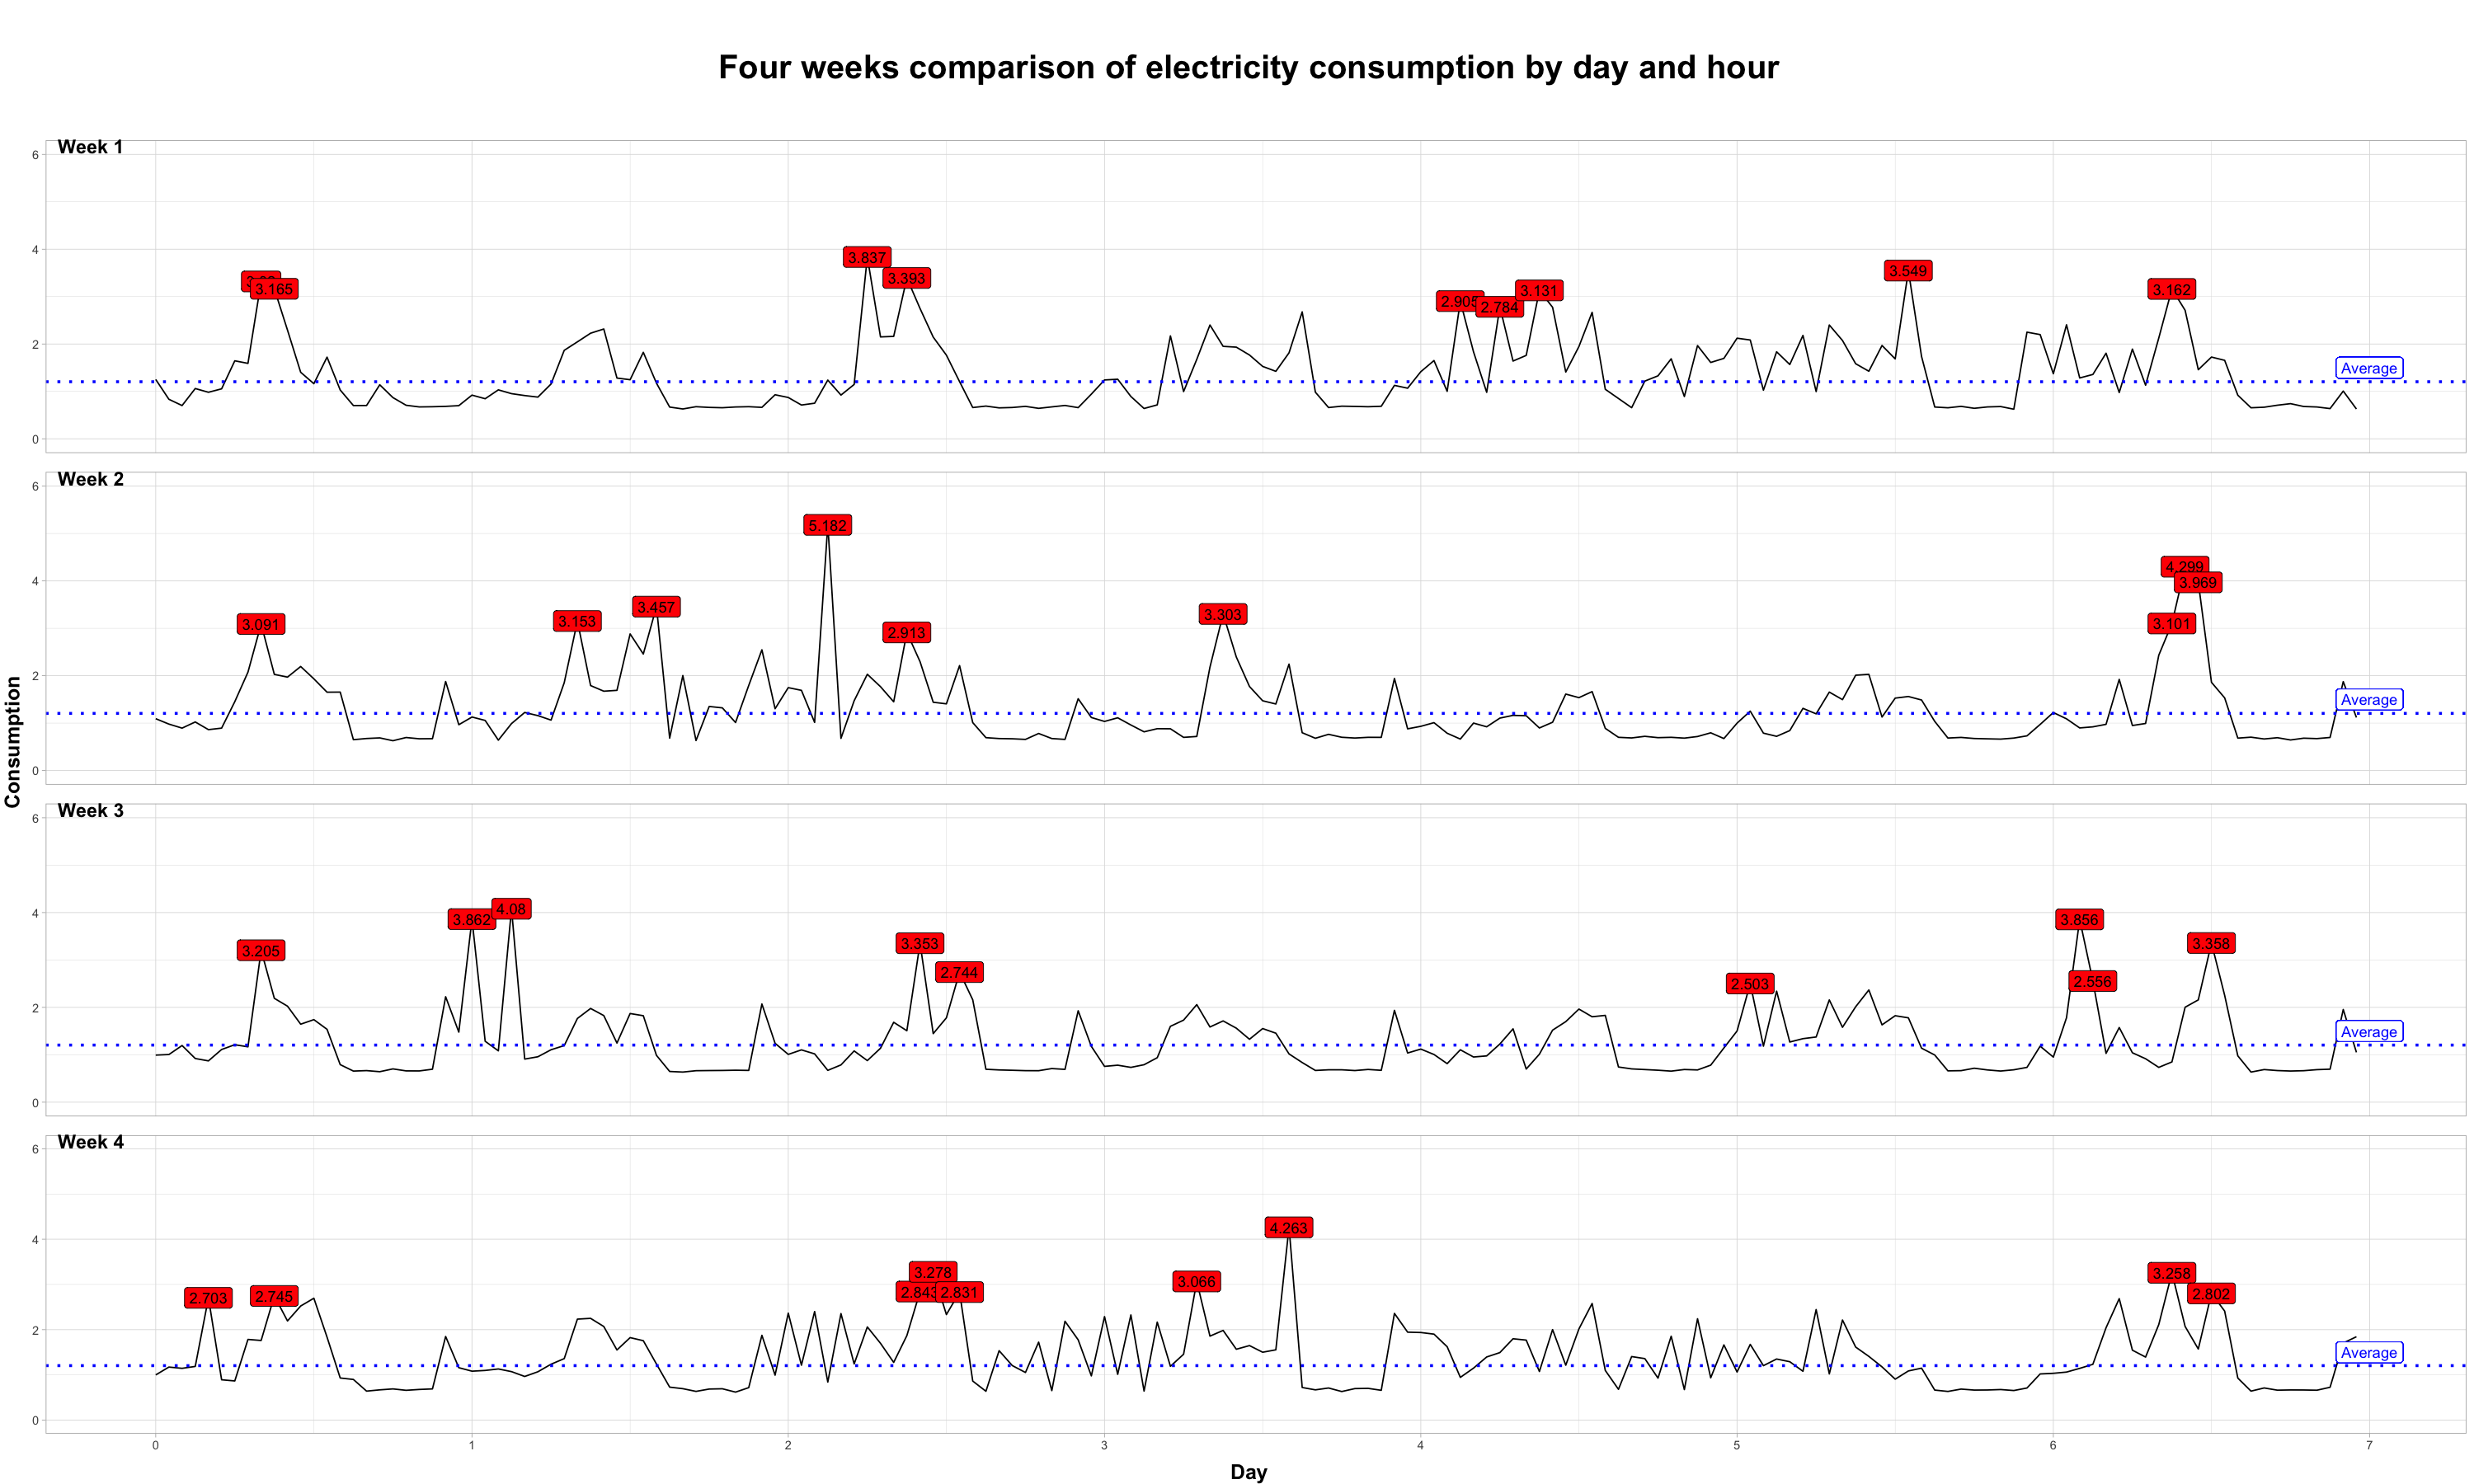

In [99]:
# Visualization of electricity consumption per day and hour
# Set configuration for plot size
options(repr.plot.width = 25, repr.plot.height = 15)

# Plot definitions
plt_wk1    <- ggplot(ElecDayHourWeekOneDF,    aes(x = instant, y = consumption)) + 
                geom_line() + 
                scale_x_continuous(breaks = 0:7, labels = 0:7) + 
                geom_label(
                    data = ElecDayHourWeekOneDF %>% filter(consumption > quantile(consumption, 0.95)),
                    aes(label=consumption),
                    color = "black",
                    fill="#ff0000"
                ) +
                theme_light()
plt_wk2    <- ggplot(ElecDayHourWeekTwoDF,    aes(x = instant, y = consumption)) + 
                geom_line()  + 
                scale_x_continuous(breaks = 0:7, labels = 0:7) + 
                geom_label(
                    data = ElecDayHourWeekTwoDF %>% filter(consumption > quantile(consumption, 0.95)),
                    aes(label=consumption),
                    color = "black",
                    fill="#ff0000"
                ) +
                theme_light()
plt_wk3    <- ggplot(ElecDayHourWeekThreeDF,    aes(x = instant, y = consumption)) +  
                geom_line()  + 
                scale_x_continuous(breaks = 0:7, labels = 0:7) + 
                geom_label(
                    data = ElecDayHourWeekThreeDF %>% filter(consumption > quantile(consumption, 0.95)),
                    aes(label=consumption),
                    color = "black",
                    fill="#ff0000"
                ) +
                theme_light()
plt_wk4    <- ggplot(ElecDayHourWeekFourDF,    aes(x = instant, y = consumption)) +  
                geom_line()  + 
                scale_x_continuous(breaks = 0:7, labels = 0:7) + 
                geom_label(
                    data = ElecDayHourWeekFourDF %>% filter(consumption > quantile(consumption, 0.95)),
                    aes(label=consumption),
                    color = "black",
                    fill="#ff0000"
                ) +
                theme_light()

# Grid of plots definition
grid_1 <- plot_grid(
    plt_wk1 + ylim(0, 6) + geom_hline(yintercept = avg_hour_consumption, color = "blue", linetype = "dotted", linewidth = 1) + 
        theme(axis.text.x = element_blank(), axis.ticks.x = element_blank(), axis.title.x = element_blank(), axis.title.y = element_blank()) + geom_label(label = "Average", x = 7, y = 1.5, color = "blue"), 
    plt_wk2 + ylim(0, 6) + geom_hline(yintercept = avg_hour_consumption, color = "blue", linetype = "dotted", linewidth = 1) + 
        theme(axis.text.x = element_blank(), axis.ticks.x = element_blank(), axis.title.x = element_blank(), axis.title.y = element_blank()) + geom_label(label = "Average", x = 7, y = 1.5, color = "blue"),
    plt_wk3 + ylim(0, 6) + geom_hline(yintercept = avg_hour_consumption, color = "blue", linetype = "dotted", linewidth = 1) + 
        theme(axis.text.x = element_blank(), axis.ticks.x = element_blank(), axis.title.x = element_blank(), axis.title.y = element_blank()) + geom_label(label = "Average", x = 7, y = 1.5, color = "blue"),
    plt_wk4 + ylim(0, 6) + geom_hline(yintercept = avg_hour_consumption, color = "blue", linetype = "dotted", linewidth = 1) +
        theme(axis.title.x = element_blank(), axis.title.y = element_blank()) + geom_label(label = "Average", x = 7, y = 1.5, color = "blue"),
    labels = c("Week 1", "Week 2", "Week 3", "Week 4"),
    label_y = 1,
    ncol = 1, nrow = 4
)
# Titles definition
title       <- ggdraw() + draw_label("Four weeks comparison of electricity consumption by day and hour", fontface = "bold", size = 24)
x_title     <- textGrob("Day", gp = gpar(fontface="bold", col="black", fontsize = 15))
y_title     <- textGrob("Consumption", gp = gpar(fontface="bold", col="black", fontsize = 15), rot=90)
plot        <- plot_grid(title, grid_1, ncol = 1, rel_heights = c(0.1, 1))
# Arrange the plot to have global x and y titles
grid.arrange(arrangeGrob(plot, bottom = x_title, left = y_title))

### b) Hourly consumption

#### Base plot and configuration

In [100]:
base_plt_hour <- ggplot(ElecHourDF, aes(x = hour, y = consumption))
base_hline_avg_hour <- geom_hline(yintercept = avg_hour_consumption, color = "blue", linetype = "dotted", linewidth = 1)
base_hline_Q95_hour <- geom_hline(yintercept = Q95_hour_consumption, color = "red", linetype = "dotted", linewidth = 1)
base_title_hour <- ggtitle("Distribution of electricity consumption by hour")
base_theme_hour <- theme_light() +
    theme(
        plot.title = element_text(hjust = 0.5, size = 24, face = "bold"),
        axis.title.x = element_text(size = 15, face = "bold"),
        axis.title.y = element_text(size = 15, face = "bold"),
        axis.text.x = element_text(size = 12),
        axis.text.y = element_text(size = 12)
    )


#### Plot 2: Scatter plot with jitter - Consumption by hour

In [101]:
maxConsDF <- ElecHourDF %>% group_by(hour) %>% summarise(max_cons = max(consumption))

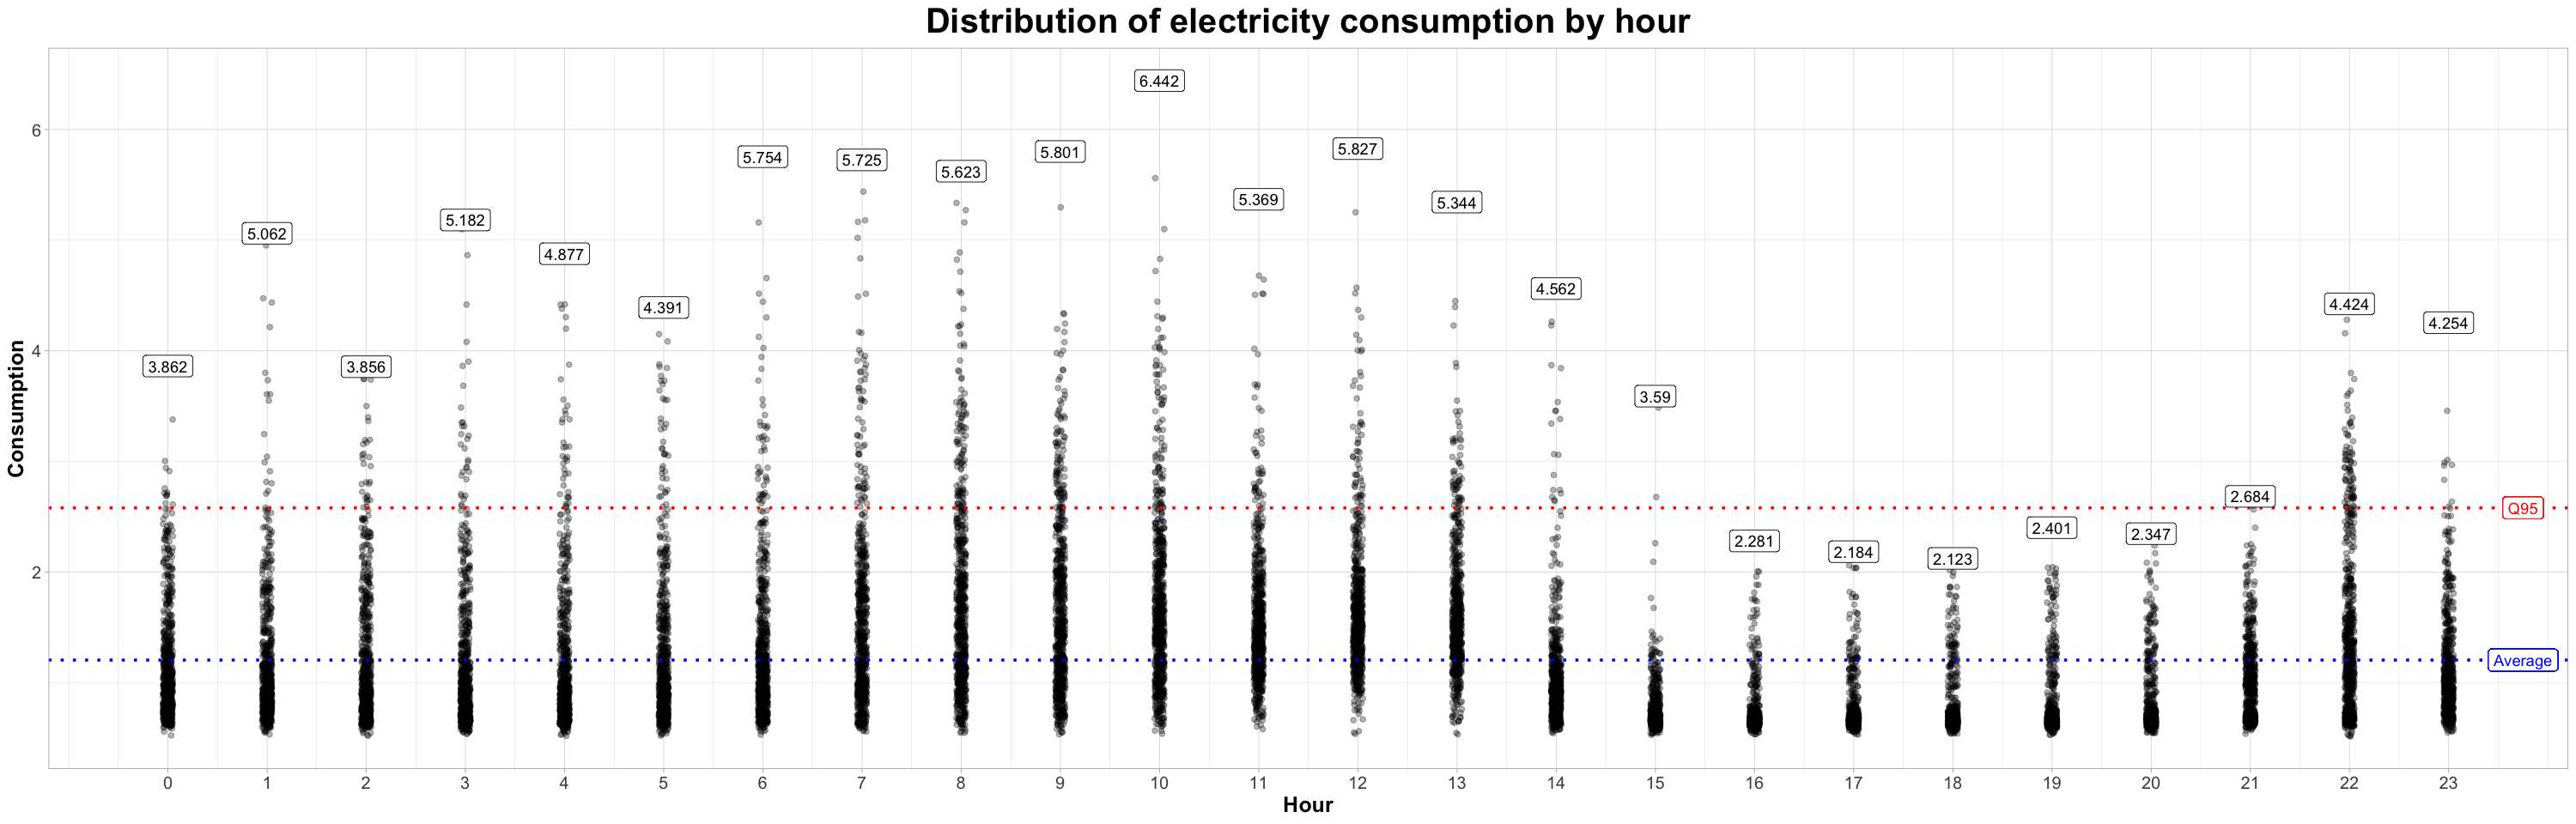

In [111]:
# Set configuration for plot size
options(repr.plot.width = 25, repr.plot.height = 8)
# Define scatter plot
base_plt_hour + 
    geom_jitter(alpha = 0.3, width = 0.05) + 
    scale_x_continuous(breaks = 0:23, labels = 0:23) +
    base_hline_avg_hour +
    base_hline_Q95_hour +
    geom_label(label = "Average", x = 23.75, y = avg_hour_consumption, color = "blue") +
    geom_label(label = "Q95", x = 23.75, y = Q95_hour_consumption, color = "red") +
    geom_label(data = ElecHourDF %>% group_by(hour) %>% summarise(consumption = max(consumption)), aes(label = consumption)) +
    labs(x = "Hour", y = "Consumption") +
    base_title_hour +
    base_theme_hour

#### Plot 3: Boxplot - Consumption by hour

In [112]:
# Set configuration for plot size
options(repr.plot.width = 25, repr.plot.height = 8)
# Define box plot
base_plt_hour + 
    geom_boxplot(aes(x = factor(hour))) + 
    base_hline_avg_hour +
    base_hline_Q95_hour +
    geom_label(label = "Average", x = 24, y = avg_hour_consumption, color = "blue") +
    geom_label(label = "Q95", x = 24, y = Q95_hour_consumption, color = "red") +
    geom_label(data = ElecHourDF %>% group_by(hour) %>% summarise(consumption = max(consumption)), aes(label = consumption)) +
    labs(x = "Hour", y = "Consumption") +
    base_title_hour +
    base_theme_hour

ERROR: Error in labs(x = "Hour", y = "Consumption") + base_title_hour: argument non num'erique pour un op'erateur binaire


: 

: 

### c) Daily consumption

In [ ]:
# Read daily electricity consumption data in csv file
ElecDayDF <- read_csv("../../../curated/electricity/gold_daily_electricity.csv", show_col_types = FALSE)

In [ ]:
# Define average consumption and outliers
avg_daily_consumption <- mean(ElecDayDF$consumption)

#### Base plot and configuration

In [ ]:
base_plt_day <- ggplot(ElecDayDF, aes(x = day, y = consumption))
base_hline_day <- geom_hline(yintercept = avg_daily_consumption, color = "blue", linetype = "dotted", size = 1)
base_title_day <- ggtitle("Distribution of electricity consumption by day")
base_theme_day <- theme_light() +
    theme(
        plot.title = element_text(hjust = 0.5, size = 24, face = "bold"),
        axis.title.x = element_text(size = 15, face = "bold"),
        axis.title.y = element_text(size = 15, face = "bold"),
        axis.text.x = element_text(size = 12),
        axis.text.y = element_text(size = 12)
    )

Warning message:
"Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
i Please use `linewidth` instead."


#### Plot 4: Boxplot - Consumption by day number

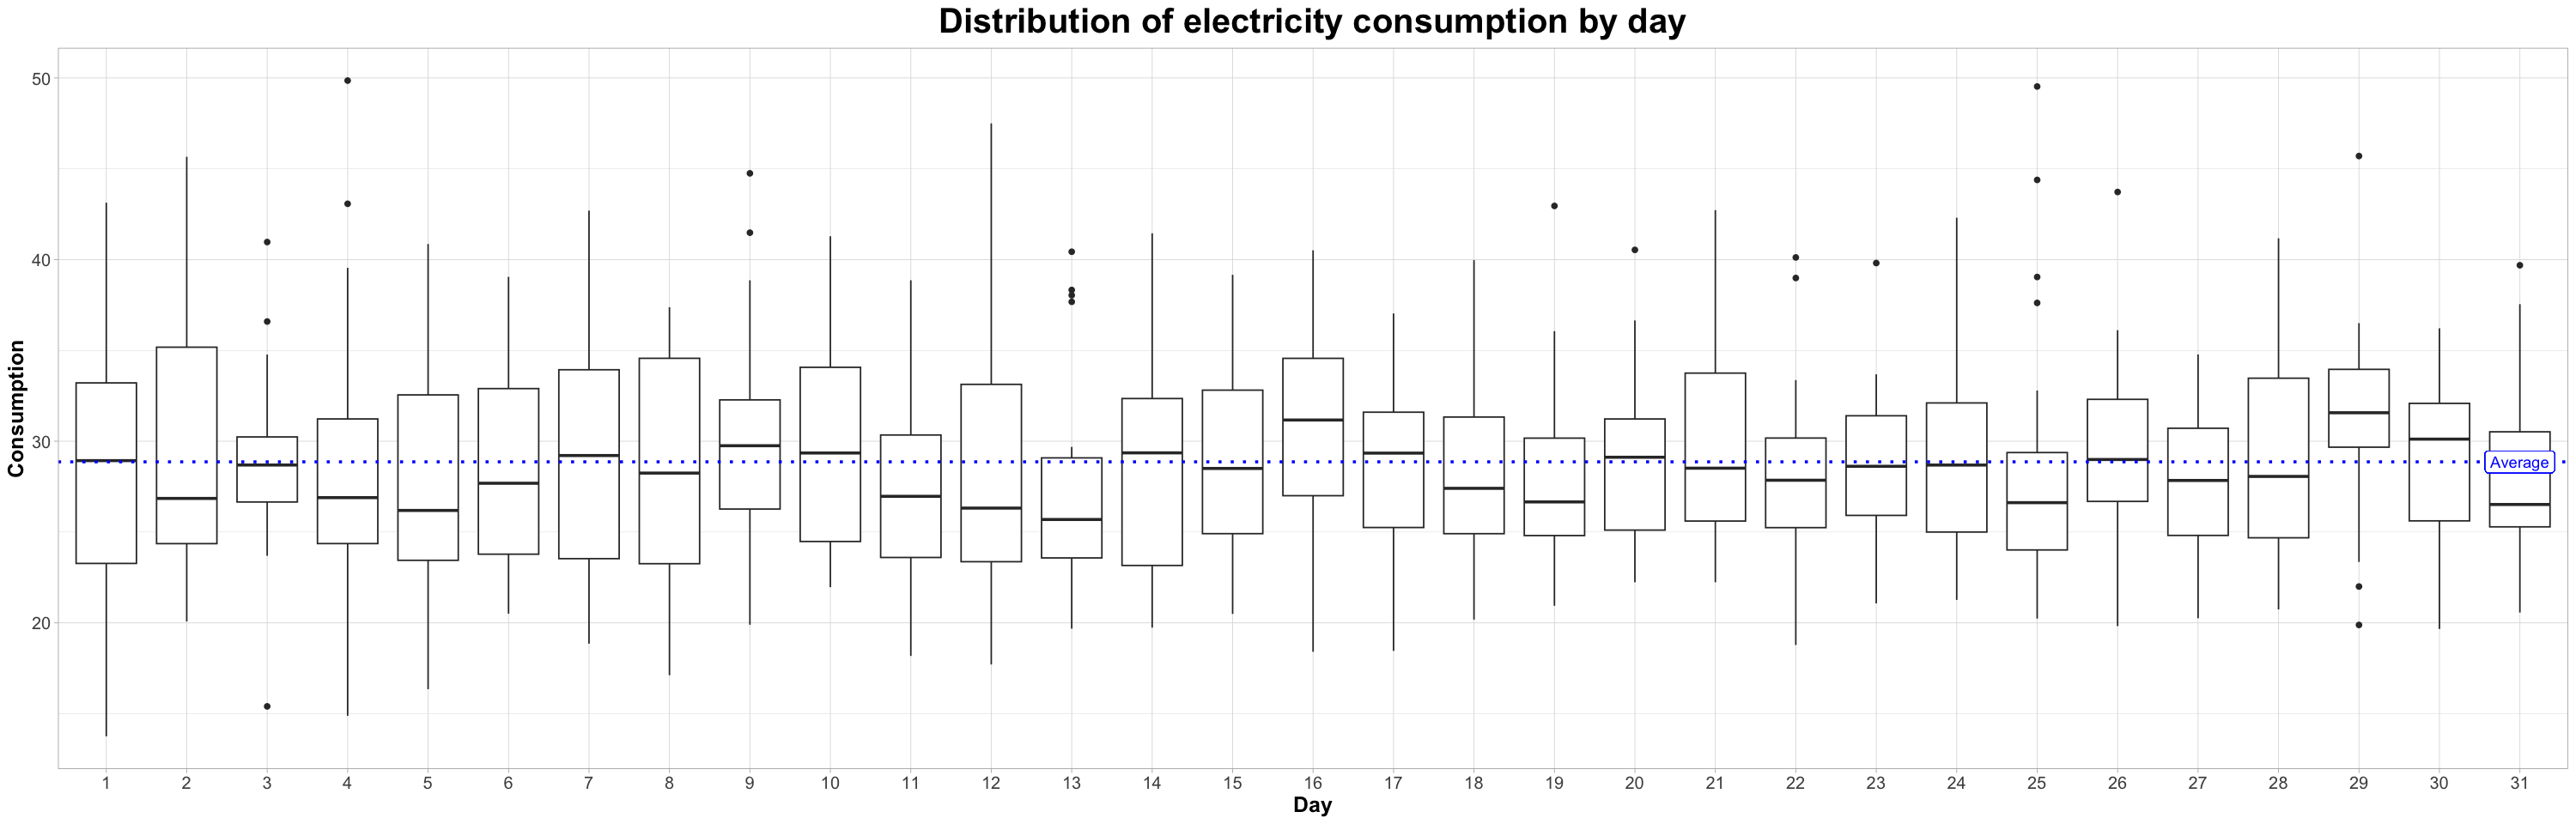

In [ ]:
# Set configuration for plot size
options(repr.plot.width = 25, repr.plot.height = 8)
# Define boxplot
base_plt_day +
    geom_boxplot(aes(x = factor(day))) +
    base_hline_day +
    geom_label(label = "Average", x = 31, y = avg_daily_consumption, color = "blue", show.legend = TRUE) +
    labs(x = "Day", y = "Consumption") +
    base_title_day + 
    base_theme_day

#### Plot 5: Line plot - Consumption by day number

In [ ]:
# Aggregate data by day number
ElecDayDF2 <- ElecDayDF %>%
    group_by(day) %>%
    summarize(
        consumption = sum(consumption)
    )
# Calculate average consumption
avg_daily_cons_2 <- mean(ElecDayDF2$consumption)

Warning message:
"Removed 1 row containing missing values (`geom_line()`)."


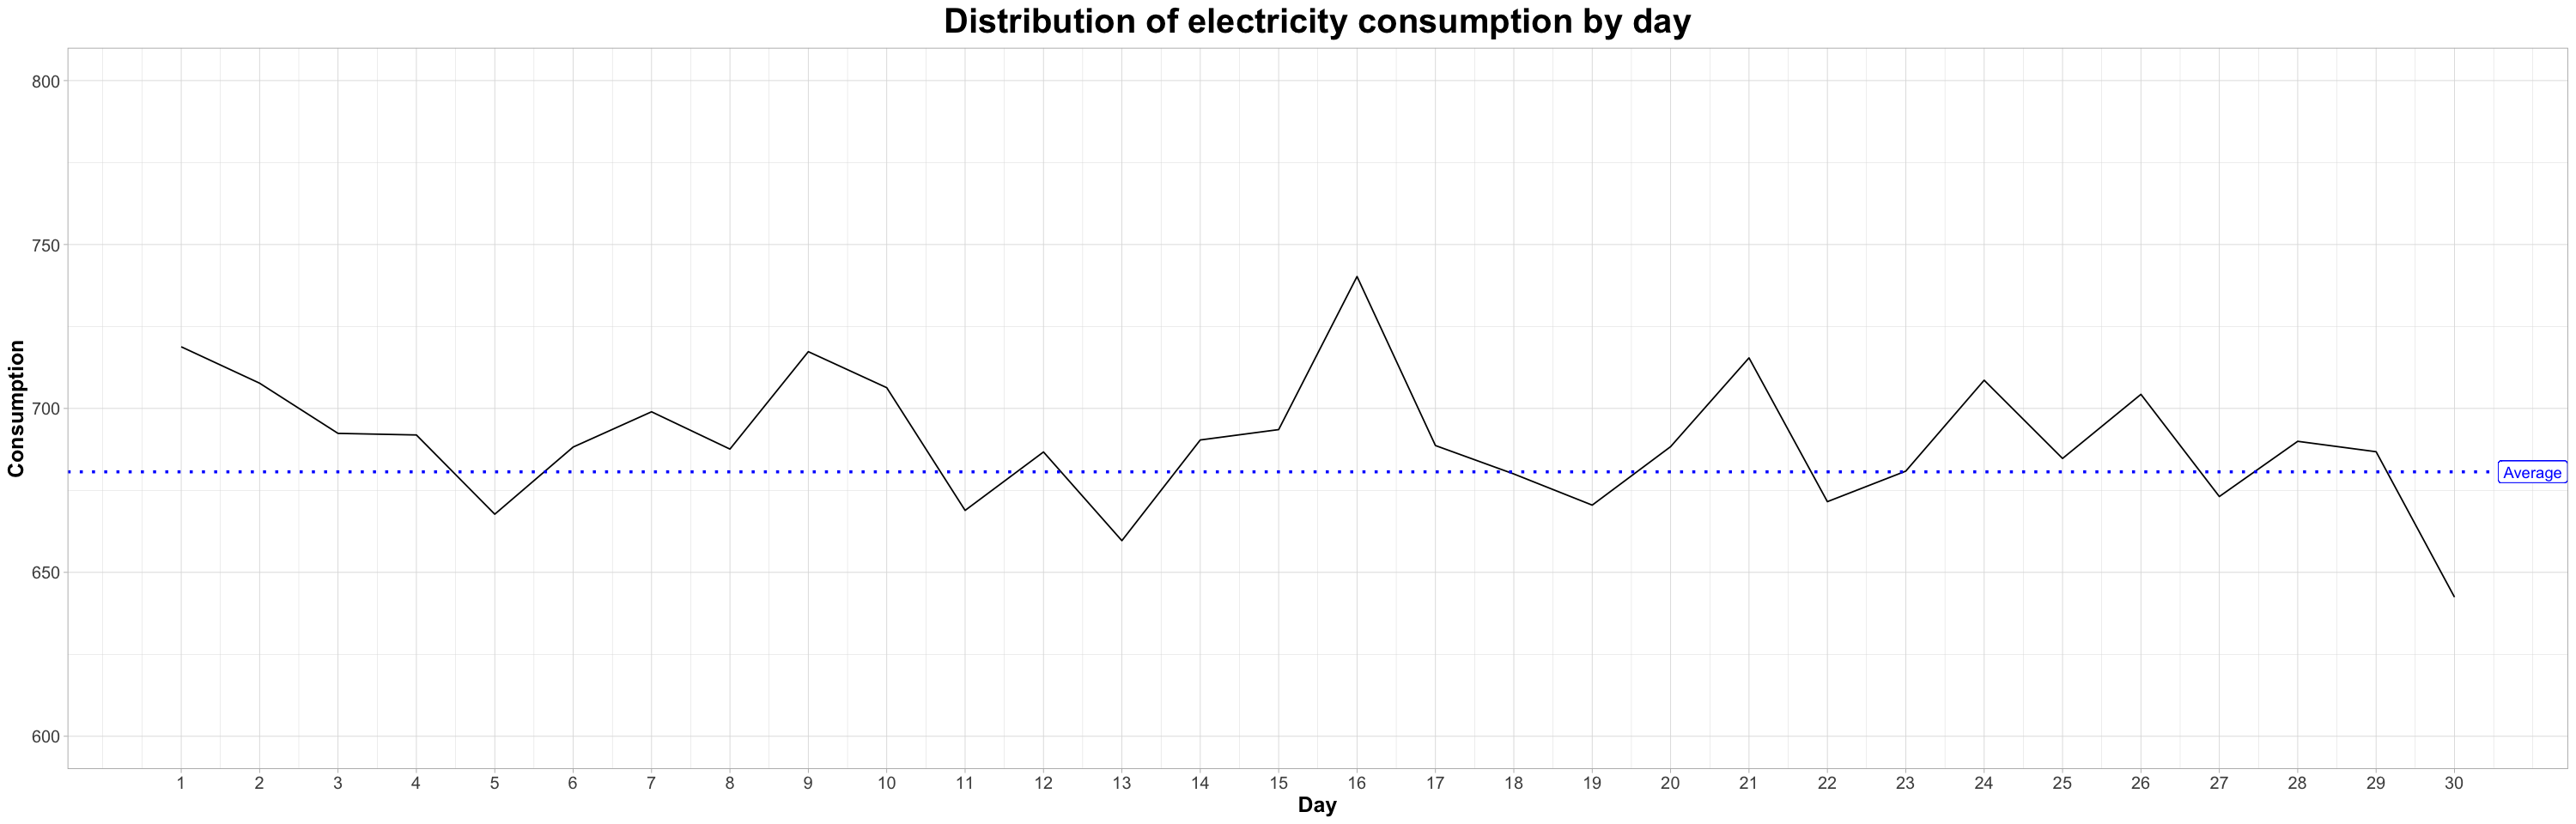

In [ ]:
# Set configuration for plot size
options(repr.plot.width = 25, repr.plot.height = 8)
# Define line plot
ggplot(ElecDayDF2, aes(x = day, y = consumption)) +
    geom_line(aes(group = 1)) +
    geom_hline(yintercept = avg_daily_cons_2, color = "blue", linetype = "dotted", size = 1) +
    scale_x_continuous(breaks = 1:30, labels = 1:30, limits = c(1, 30)) +
    ylim(c(600,800)) +
    geom_label(label = "Average", x = 31, y = avg_daily_cons_2, color = "blue") +
    labs(x = "Day", y = "Consumption") +
    base_title_day + 
    base_theme_day

### d) Monthly consumption

In [ ]:
# Read monthly electricity consumption data in csv file
ElecMonthDF <- read_csv("../../../curated/electricity/gold_monthly_electricity.csv", show_col_types = FALSE)

In [ ]:
# Define average consumption and outliers
avg_monthly_consumption <- mean(ElecMonthDF$consumption)
# Threshold: 95%
ElecMonthDF <- ElecMonthDF %>%
    mutate(
        isOutlier = consumption > quantile(consumption, 0.95),
        month_str = ifelse(nchar(month) == 1, paste0("0", as.character(month)), as.character(month)),
        year_month = factor(paste(year, month_str, sep = "-"))
    ) %>%
    select(-month_str)

#### Base plot and configuration

In [ ]:
base_plt_month <- ggplot(ElecMonthDF, aes(x = month, y = consumption))
base_hline_month <- geom_hline(yintercept = avg_monthly_consumption, color = "blue", linetype = "dotted", size = 1)
base_title_month <- ggtitle("Distribution of electricity consumption by month")
base_theme_month <- theme_light() +
    theme(
        plot.title = element_text(hjust = 0.5, size = 24, face = "bold"),
        axis.title.x = element_text(size = 15, face = "bold"),
        axis.title.y = element_text(size = 15, face = "bold"),
        axis.text.x = element_text(size = 12),
        axis.text.y = element_text(size = 12)
    )

#### Plot 6: Boxplot - Consumption by month

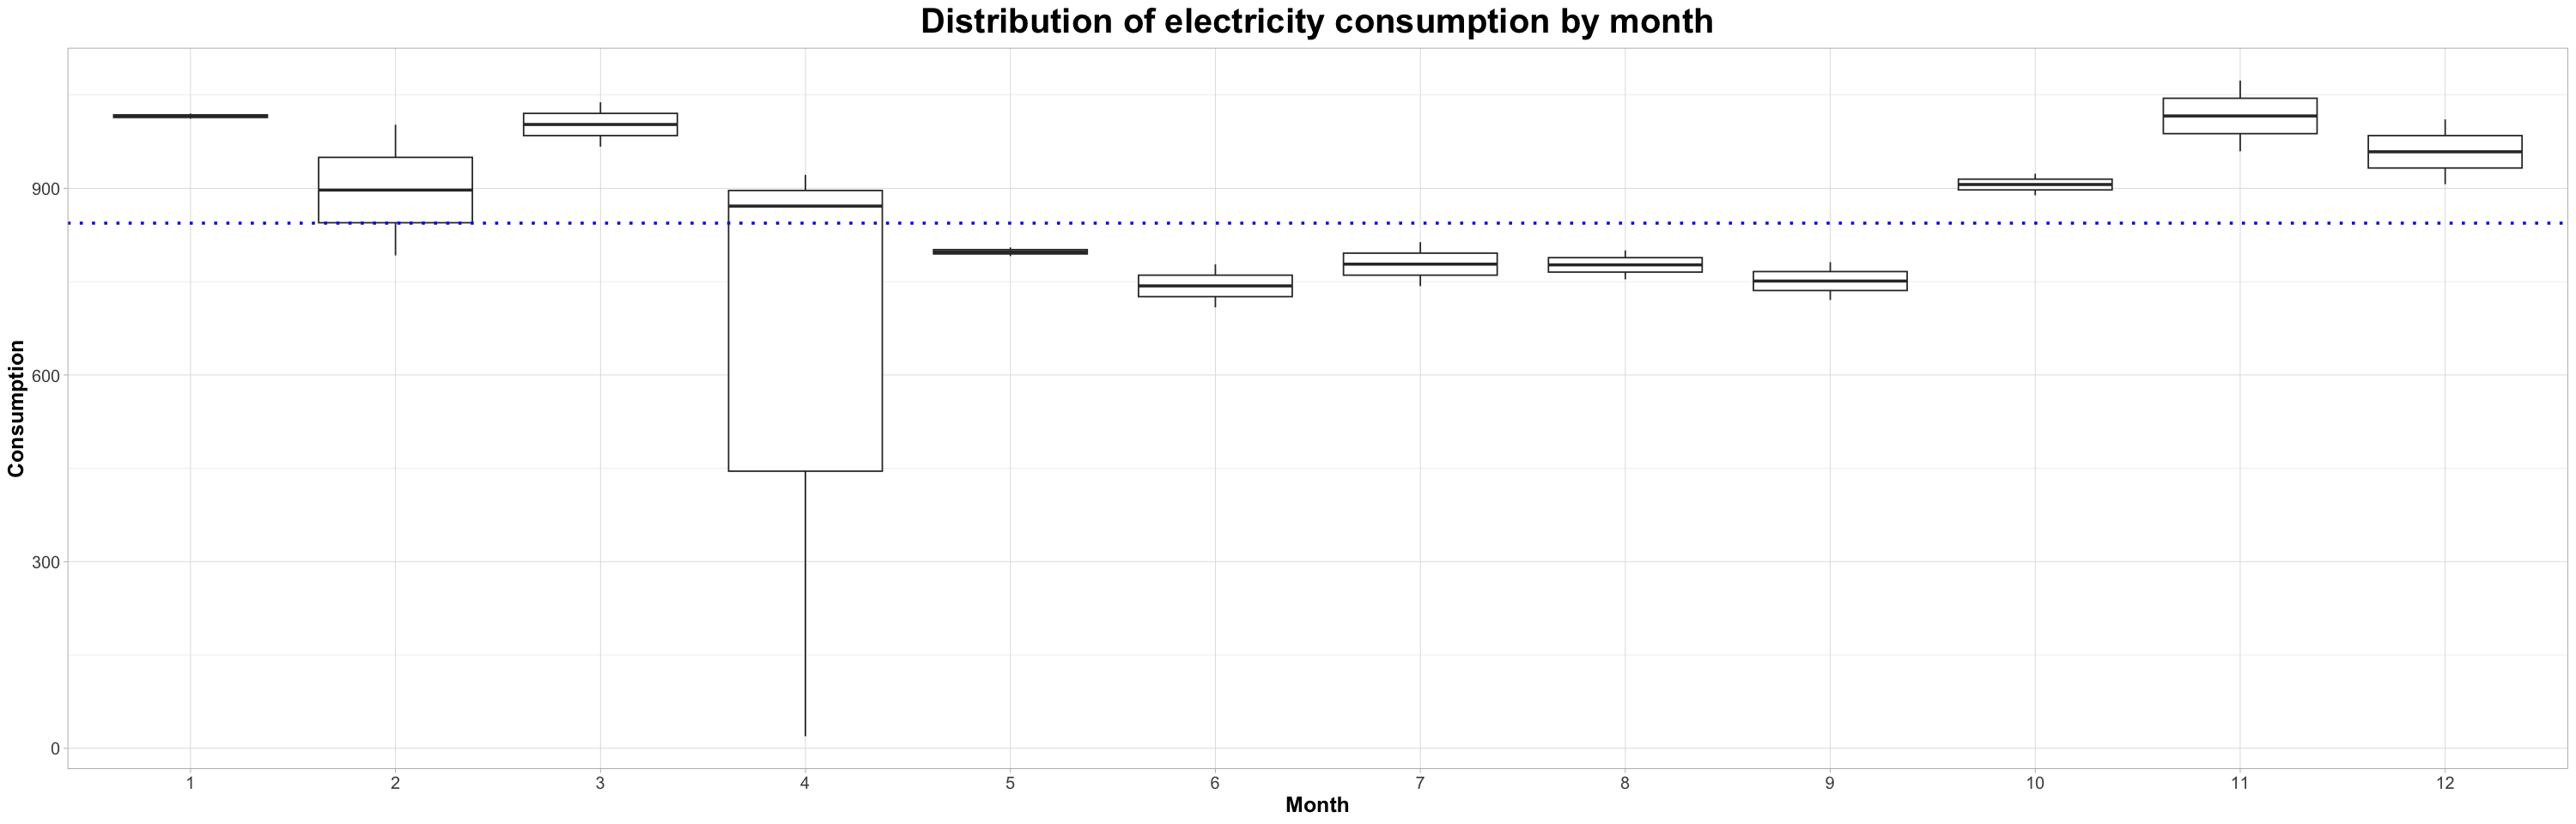

In [ ]:
# Set configuration for plot size
options(repr.plot.width = 25, repr.plot.height = 8)
# Define boxplot
base_plt_month +
    geom_boxplot(aes(x = factor(month))) +
    base_hline_month +
    geom_label(label = "Average", x = 31, y = avg_monthly_consumption, color = "blue", show.legend = TRUE) +
    labs(x = "Month", y = "Consumption") +
    base_title_month + 
    base_theme_month

#### Plot 7: Line plot - Consumption by month

In [ ]:
# Aggregate data by month number
ElecMonthDF2 <- ElecMonthDF %>%
    group_by(month) %>%
    summarize(
        consumption = sum(consumption)
    )
# Calculate average consumption
avg_monthly_cons_2 <- mean(ElecMonthDF2$consumption)

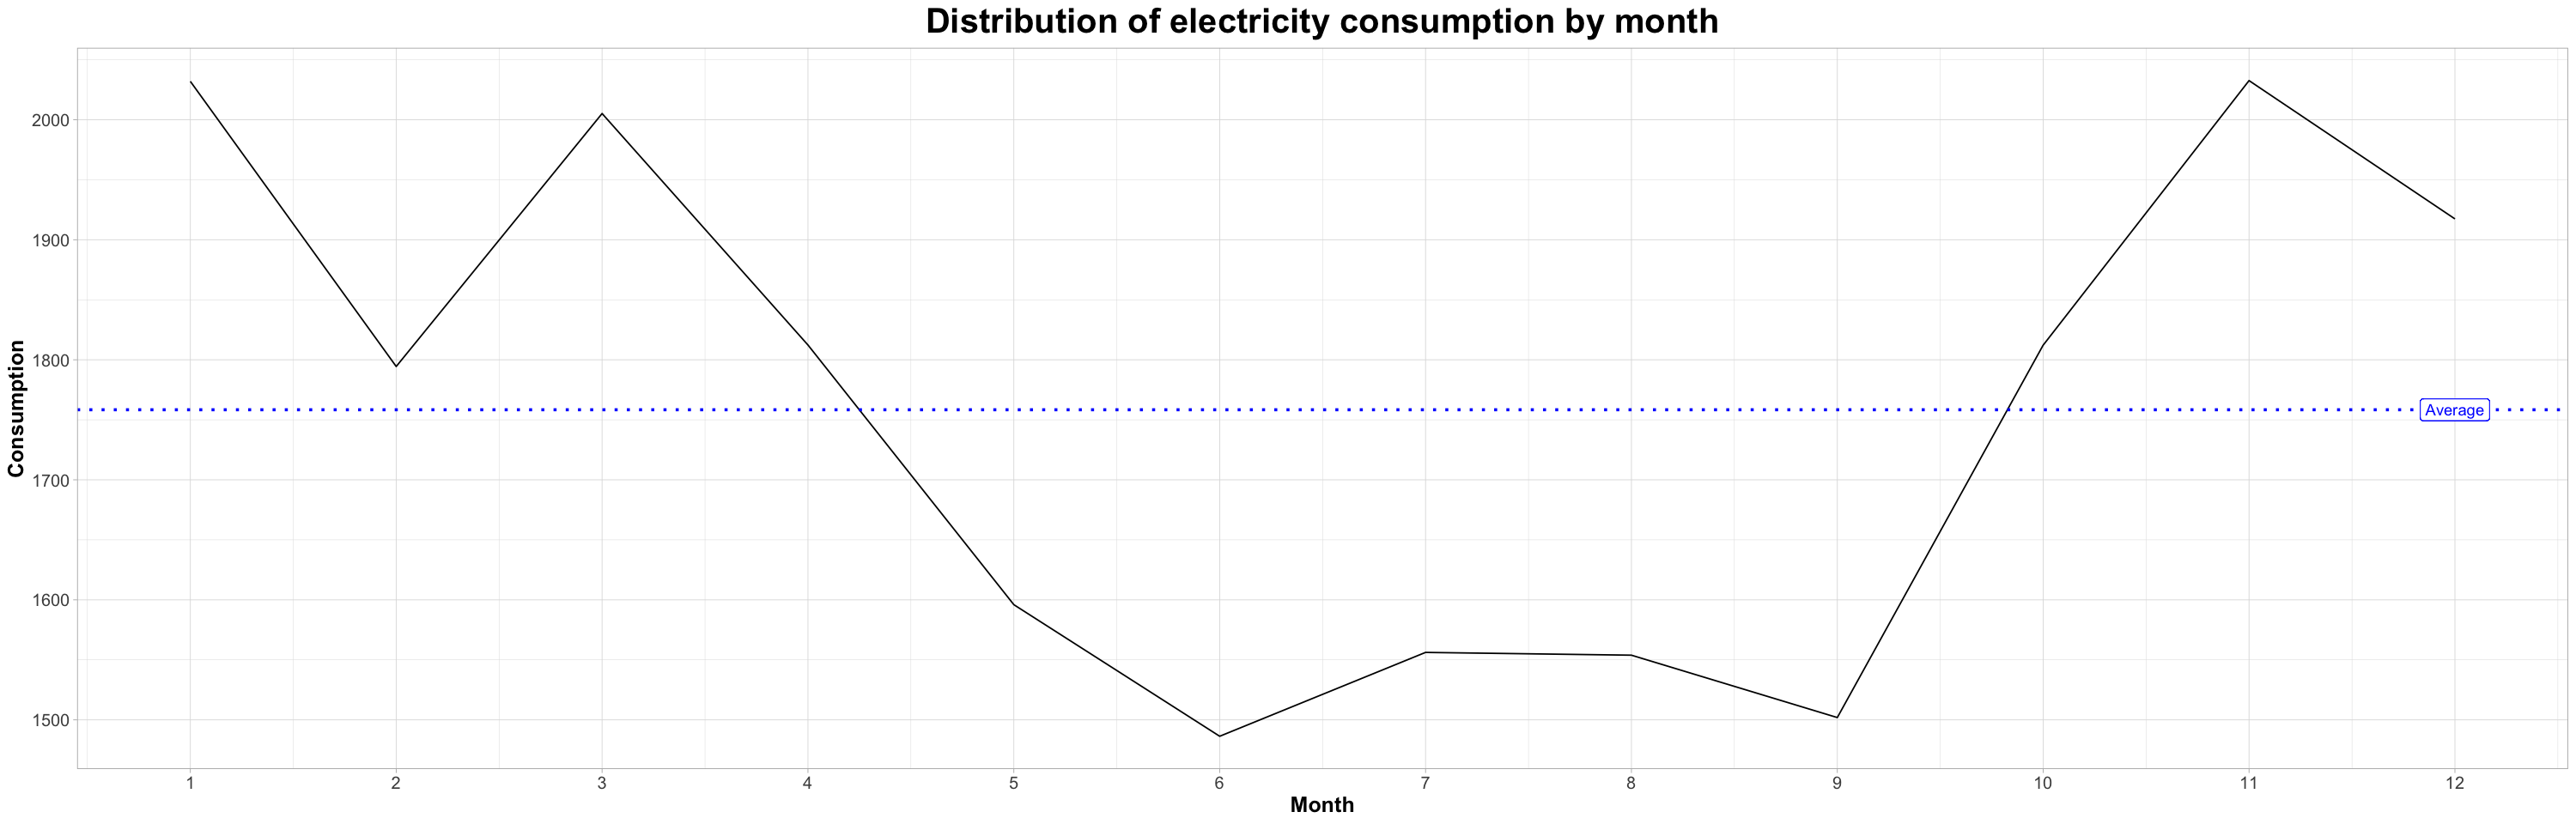

In [ ]:
# Set configuration for plot size
options(repr.plot.width = 25, repr.plot.height = 8)
# Define line plot
ggplot(ElecMonthDF2, aes(x = month, y = consumption)) +
    geom_line(aes(group = 1)) +
    geom_hline(yintercept = avg_monthly_cons_2, color = "blue", linetype = "dotted", size = 1) +
    scale_x_continuous(breaks = 1:12, labels = 1:12, limits = c(1, 12)) +
    geom_label(label = "Average", x = 12, y = avg_monthly_cons_2, color = "blue") +
    labs(x = "Month", y = "Consumption") +
    base_title_month + 
    base_theme_month

#### Plot 8: Line plot - Consumption by year and month

Warning message:
"Removed 1 row containing missing values (`geom_line()`)."


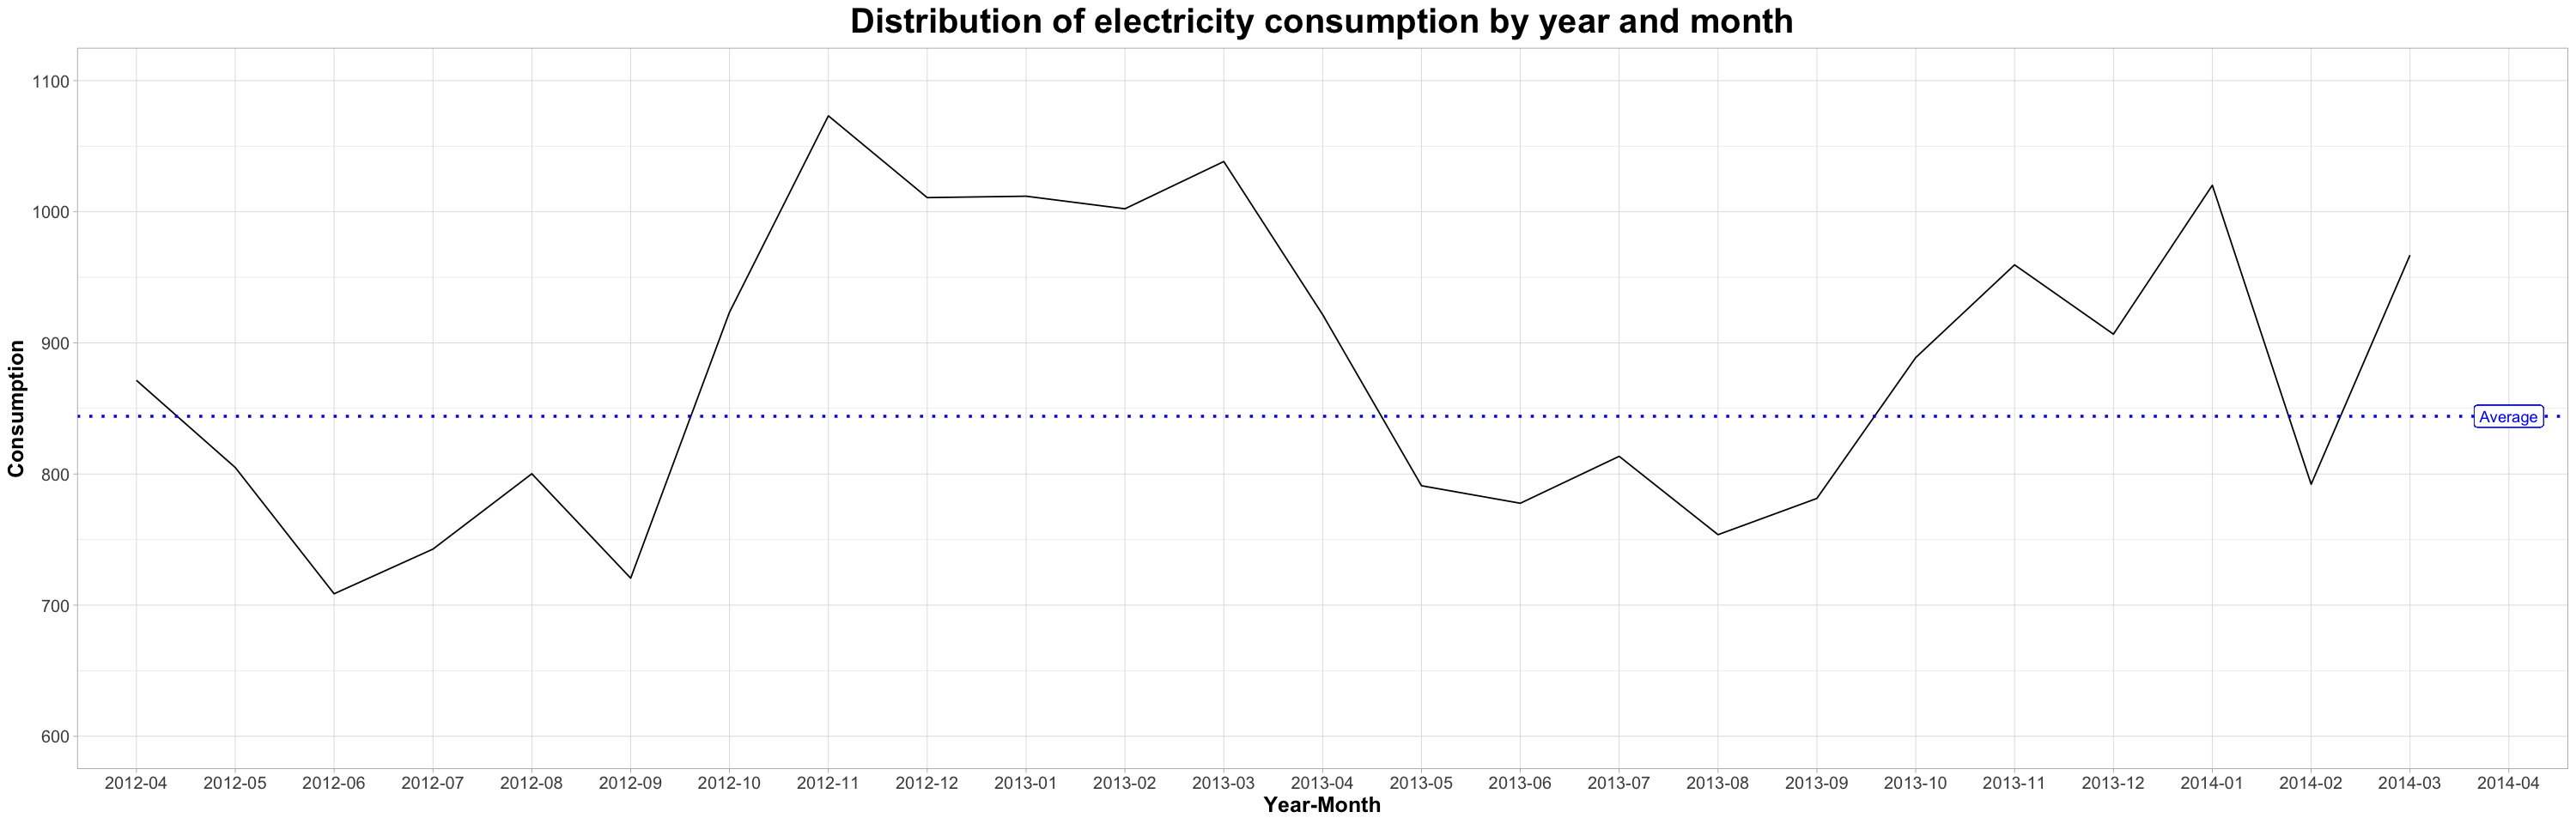

In [ ]:
# Set configuration for plot size
options(repr.plot.width = 25, repr.plot.height = 8)
# Define line plot
base_plt_month +
    geom_line(aes(x = factor(year_month), group = 1)) +
    base_hline_month +
    ylim(c(600, 1100)) +
    geom_label(label = "Average", x = "2014-04", y = avg_monthly_consumption, color = "blue", show.legend = TRUE) +
    labs(x = "Year-Month", y = "Consumption") +
    ggtitle("Distribution of electricity consumption by year and month") + 
    base_theme_month